In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from datetime import datetime
from tensorflow.keras.metrics import top_k_categorical_accuracy, CategoricalHinge, Recall, Precision
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import metrics

import tensorflow.keras
from tensorflow.compat.v2.keras.layers import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
tf.compat.v1.disable_eager_execution
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

#np.random.seed(368)
#tf.random.set_seed(368)

In [2]:
xfile='C:\\workspace\\j6stock\\xau_usd_OHLC1.0Tp1.0Cl100Vp.txt'

seq_len = 60*24*1+720 # 3 days + 2 features is enough memory
batch_size = 2048*2+200       # Batch size
mini_batch_size = 64       # Batch size

learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 1


y_column = 6
compute_val_at = 0
acc_filtered_r = 0.8


import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
#from keras.models import load_model
#import keras
import pandas as pd ## can be remove once pandas_datareader 0.7 using
pd.core.common.is_list_like = pd.api.types.is_list_like ## can be remove once pandas_datareader 0.7 using
import pandas_datareader.data as web
import h5py
import os

#from keras import backend as K

def make_window_dataset(ds, window_size=5, shift=1, stride=1):
    windows = ds.window(window_size, shift=shift, stride=stride)

    def sub_to_batch(sub, y):
        print (sub)
        print (y)
        s = sub.batch(window_size, drop_remainder=True)
        yy = y.batch(window_size, drop_remainder=True)
        return (s, yy)

    windows = windows.flat_map(sub_to_batch)
    return windows


def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    df['tail'] = df['low']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
        df.at[i, 'tail'] = df.at[i, 'high'] if df.at[i, 'high'] > df.at[i, 'low'] else ( df.at[i, 'low'] * -1)
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
    
        
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        #df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        #df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        df['tail'] = min_max_scaler.fit_transform(df['tail'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
    
    #drop for wavenet and not enough memory
    #df.drop(labels=['change'], axis=1, inplace=True)
    df.drop(labels=['high'], axis=1, inplace=True)
    df.drop(labels=['low'], axis=1, inplace=True)
    
    return df

#df = get_stock_data( ma=[50, 100, 200])
df = get_stock_data()

amount_of_features = len(df.columns)-1

def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    print ("Amount of data = {}".format(y_result.shape[0]))

    percentageSplit = 0.5 # 60% split
    row = round(percentageSplit * y_result.shape[0]) 
    print ("Split = {}".format(row))
 
    X_train = x_result[:int(row), :] 
    y_train = y_result[:int(row)] 
    print ("Amount of training data = {}".format(y_train.shape[0]))
    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    
    # split 50% again for test and validation set
    row = round(percentageSplit * y_test.shape[0]) 
    X_val = X_test[int(row):, :]
    y_val = y_test[int(row):]
    print ("Amount of validation data = {}".format(y_val.shape[0]))
    X_test = X_test[:int(row), :]
    y_test = y_test[:int(row)]
    print ("Amount of testing data = {}".format(y_test.shape[0]))
    

           
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test,X_val,y_val]



classes = [1, 0, -1]
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.transform([-1, 0, 1])

X_tr, lab_tr, X_test, lab_test, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
y_test = lb.transform(lab_test)


train_X = X_tr
train_y = y_tr
valid_X = X_vld
valid_y = y_vld
test_X = X_test
test_y = y_test
print(train_X.shape)
print(train_y[0])
print(train_y[1])
print(train_y[2])

Amount of features = 3


C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction\lib\site-packages\ipykernel_launcher.py:114: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Amount of data = 93358
Split = 46679
Amount of training data = 46679
Amount of validation data = 22417
Amount of testing data = 22417
(46679, 2160, 3)
[1 0 0]
[1 0 0]
[1 0 0]


In [3]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [4]:
def CnnTransformerModel():
#    i = tf.compat.v2.keras.layers.Flatten(input_shape=(batch_size, amount_of_features))
    i = tf.compat.v2.keras.layers.Input(shape = (seq_len, amount_of_features)#, batch_size=mini_batch_size
                                       )
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 4, strides = 2, activation='relu')(i)
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 4, strides = 2, activation='relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 4, strides = 2, activation='relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 4, strides = 2, activation='relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 4, strides = 2, activation='relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 4, strides = 2, activation='relu')(x)
    
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(i)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
 
#    x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=15, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pool, max_pool])
    y = Dense(3,activation = 'relu')(concat)
    

    return Model(inputs = [i], outputs = [y])

In [5]:
model = CnnTransformerModel()
optimizer = tf.keras.optimizers.Adam(lr=0.090, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy' 
#                             , metrics=[Recall() #Recall(thresholds=0.5, class_id=0, top_k=1)
                       #           , Recall(thresholds=0.5, class_id=2, top_k=1)
                      #              , Precision(thresholds=0.5, class_id=0, top_k=1)
                       #            , Precision(thresholds=0.5, class_id=2, top_k=1)
#                                   ]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2160, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1079, 16)     208         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 538, 16)      1040        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 268, 16)      1040        conv1d_1[0][0]                   
______________________________________________________________________________________________

**Visualizing The Model Architecture**

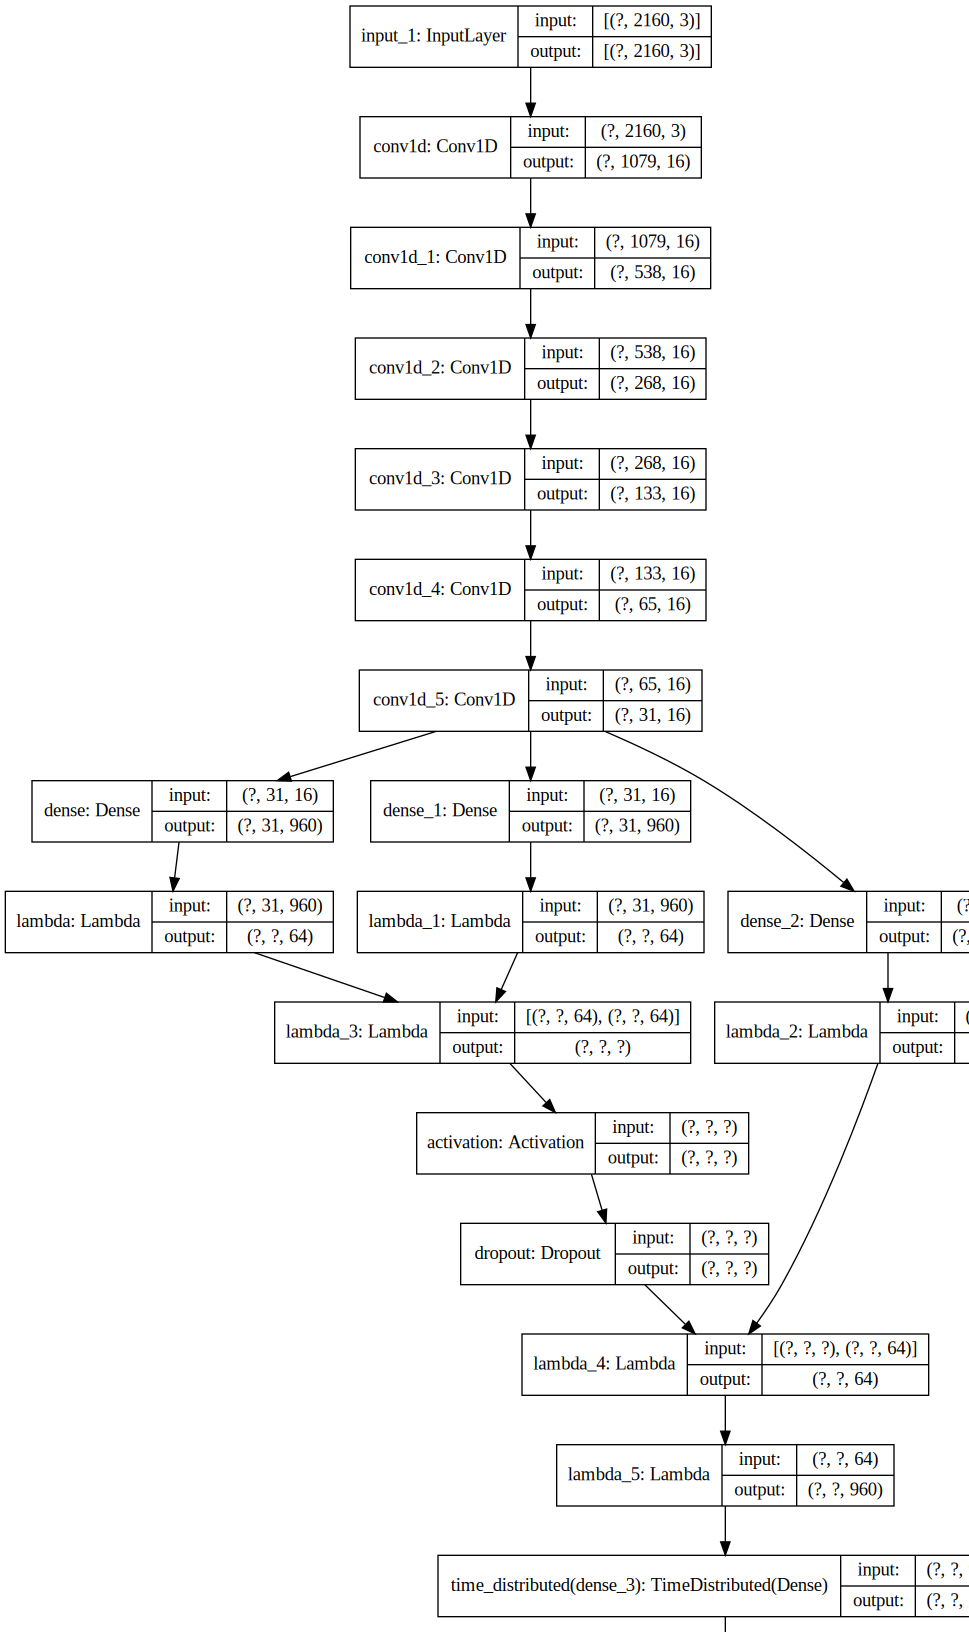

In [6]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [7]:
from datetime import datetime
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=500) 
callbacks_list = [checkpoint
                  , early
                  , reduceLROnPlat
                  , tensorboard_callback
                 ]

from IPython.display import clear_output
model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 500,
                      callbacks = callbacks_list)
#clear_output()

W1009 16:26:29.281099 15304 callbacks.py:1781] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 46679 samples, validate on 22417 samples


W1009 16:26:29.482144 15304 summary_ops_v2.py:1110] Model failed to serialize as JSON. Ignoring... Layers with arguments in `__init__` must override `get_config`.


Epoch 1/500


W1009 16:26:29.766216 15304 deprecation.py:323] From C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


42960/46679 [==========================>...] - ETA: 1:33 - loss: 10.16 - ETA: 44s - loss: 5.6708 - ETA: 27s - loss: 4.16 - ETA: 18s - loss: 3.42 - ETA: 12s - loss: 2.96 - ETA: 9s - loss: 2.6627 - ETA: 6s - loss: 2.442 - ETA: 4s - loss: 2.283 - ETA: 2s - loss: 2.159 - ETA: 1s - loss: 2.0605
Epoch 00001: val_loss improved from inf to 0.69458, saving model to stroke_lstm_model_weights.best.hdf5
46679/46679 [==============================] - 21s 451us/sample - loss: 1.9856 - val_loss: 0.6946
Epoch 2/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.149 - ETA: 5s - loss: 1.113 - ETA: 4s - loss: 1.120 - ETA: 4s - loss: 1.132 - ETA: 4s - loss: 1.142 - ETA: 3s - loss: 1.142 - ETA: 2s - loss: 1.145 - ETA: 1s - loss: 1.141 - ETA: 1s - loss: 1.141 - ETA: 0s - loss: 1.1438
Epoch 00002: val_loss did not improve from 0.69458
46679/46679 [==============================] - 9s 199us/sample - loss: 1.1492 - val_loss: 4.0567
Epoch 3/500
42960/46679 [==========================>...] - ET

42960/46679 [==========================>...] - ETA: 3s - loss: 1.145 - ETA: 2s - loss: 1.161 - ETA: 2s - loss: 1.155 - ETA: 2s - loss: 1.141 - ETA: 1s - loss: 1.144 - ETA: 1s - loss: 1.150 - ETA: 1s - loss: 1.148 - ETA: 0s - loss: 1.150 - ETA: 0s - loss: 1.153 - ETA: 0s - loss: 1.1480
Epoch 00035: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 104us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 36/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.138 - ETA: 2s - loss: 1.097 - ETA: 2s - loss: 1.125 - ETA: 2s - loss: 1.144 - ETA: 1s - loss: 1.146 - ETA: 1s - loss: 1.146 - ETA: 1s - loss: 1.147 - ETA: 0s - loss: 1.157 - ETA: 0s - loss: 1.149 - ETA: 0s - loss: 1.1470
Epoch 00036: val_loss did not improve from 0.69315

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.05760000348091126.
46679/46679 [==============================] - 5s 104us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 37/500
42960/46679 [==============

42960/46679 [==========================>...] - ETA: 3s - loss: 1.174 - ETA: 3s - loss: 1.122 - ETA: 2s - loss: 1.121 - ETA: 2s - loss: 1.127 - ETA: 2s - loss: 1.128 - ETA: 1s - loss: 1.137 - ETA: 1s - loss: 1.143 - ETA: 1s - loss: 1.149 - ETA: 0s - loss: 1.151 - ETA: 0s - loss: 1.1527
Epoch 00071: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 114us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 72/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.145 - ETA: 3s - loss: 1.124 - ETA: 2s - loss: 1.136 - ETA: 2s - loss: 1.138 - ETA: 2s - loss: 1.139 - ETA: 1s - loss: 1.146 - ETA: 1s - loss: 1.141 - ETA: 1s - loss: 1.150 - ETA: 0s - loss: 1.147 - ETA: 0s - loss: 1.1545
Epoch 00072: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 114us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 73/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.145 - ETA: 3s - loss: 1.161 - ETA: 2s - l

Epoch 107/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.163 - ETA: 3s - loss: 1.165 - ETA: 3s - loss: 1.171 - ETA: 2s - loss: 1.163 - ETA: 2s - loss: 1.154 - ETA: 1s - loss: 1.140 - ETA: 1s - loss: 1.142 - ETA: 1s - loss: 1.142 - ETA: 0s - loss: 1.143 - ETA: 0s - loss: 1.1498
Epoch 00107: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 110us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 108/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.163 - ETA: 2s - loss: 1.168 - ETA: 2s - loss: 1.159 - ETA: 2s - loss: 1.156 - ETA: 1s - loss: 1.157 - ETA: 1s - loss: 1.147 - ETA: 1s - loss: 1.151 - ETA: 0s - loss: 1.148 - ETA: 0s - loss: 1.146 - ETA: 0s - loss: 1.1495
Epoch 00108: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 106us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 109/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.145 - ETA: 2s - loss: 1.1

42960/46679 [==========================>...] - ETA: 3s - loss: 1.127 - ETA: 2s - loss: 1.131 - ETA: 2s - loss: 1.126 - ETA: 2s - loss: 1.134 - ETA: 1s - loss: 1.143 - ETA: 1s - loss: 1.137 - ETA: 1s - loss: 1.136 - ETA: 0s - loss: 1.134 - ETA: 0s - loss: 1.139 - ETA: 0s - loss: 1.1441
Epoch 00143: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 105us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 144/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.213 - ETA: 2s - loss: 1.177 - ETA: 2s - loss: 1.165 - ETA: 2s - loss: 1.155 - ETA: 1s - loss: 1.141 - ETA: 1s - loss: 1.140 - ETA: 1s - loss: 1.142 - ETA: 0s - loss: 1.143 - ETA: 0s - loss: 1.143 - ETA: 0s - loss: 1.1448
Epoch 00144: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 106us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 145/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.152 - ETA: 2s - loss: 1.183 - ETA: 2s -

Epoch 179/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.127 - ETA: 2s - loss: 1.115 - ETA: 2s - loss: 1.145 - ETA: 2s - loss: 1.137 - ETA: 1s - loss: 1.139 - ETA: 1s - loss: 1.142 - ETA: 1s - loss: 1.151 - ETA: 0s - loss: 1.146 - ETA: 0s - loss: 1.151 - ETA: 0s - loss: 1.1480
Epoch 00179: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 102us/sample - loss: 1.1491 - val_loss: 0.6931
Epoch 180/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.170 - ETA: 2s - loss: 1.211 - ETA: 2s - loss: 1.189 - ETA: 2s - loss: 1.182 - ETA: 1s - loss: 1.156 - ETA: 1s - loss: 1.154 - ETA: 1s - loss: 1.155 - ETA: 0s - loss: 1.153 - ETA: 0s - loss: 1.153 - ETA: 0s - loss: 1.1552
Epoch 00180: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 101us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 181/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.120 - ETA: 2s - loss: 1.1

42960/46679 [==========================>...] - ETA: 3s - loss: 1.080 - ETA: 3s - loss: 1.158 - ETA: 2s - loss: 1.152 - ETA: 2s - loss: 1.144 - ETA: 1s - loss: 1.143 - ETA: 1s - loss: 1.140 - ETA: 1s - loss: 1.147 - ETA: 0s - loss: 1.151 - ETA: 0s - loss: 1.152 - ETA: 0s - loss: 1.1545
Epoch 00215: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 108us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 216/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.127 - ETA: 2s - loss: 1.122 - ETA: 2s - loss: 1.140 - ETA: 2s - loss: 1.144 - ETA: 1s - loss: 1.157 - ETA: 1s - loss: 1.150 - ETA: 1s - loss: 1.144 - ETA: 0s - loss: 1.144 - ETA: 0s - loss: 1.140 - ETA: 0s - loss: 1.1466
Epoch 00216: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 106us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 217/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.102 - ETA: 2s - loss: 1.145 - ETA: 2s -

Epoch 233/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.081 - ETA: 2s - loss: 1.100 - ETA: 2s - loss: 1.113 - ETA: 2s - loss: 1.127 - ETA: 1s - loss: 1.132 - ETA: 1s - loss: 1.137 - ETA: 1s - loss: 1.142 - ETA: 0s - loss: 1.149 - ETA: 0s - loss: 1.146 - ETA: 0s - loss: 1.1455
Epoch 00233: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 103us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 234/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.174 - ETA: 2s - loss: 1.129 - ETA: 2s - loss: 1.156 - ETA: 2s - loss: 1.145 - ETA: 1s - loss: 1.134 - ETA: 1s - loss: 1.145 - ETA: 1s - loss: 1.142 - ETA: 0s - loss: 1.140 - ETA: 0s - loss: 1.145 - ETA: 0s - loss: 1.1470
Epoch 00234: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 108us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 235/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.192 - ETA: 2s - loss: 1.1

42960/46679 [==========================>...] - ETA: 3s - loss: 1.181 - ETA: 2s - loss: 1.186 - ETA: 2s - loss: 1.152 - ETA: 2s - loss: 1.154 - ETA: 1s - loss: 1.154 - ETA: 1s - loss: 1.146 - ETA: 1s - loss: 1.140 - ETA: 0s - loss: 1.145 - ETA: 0s - loss: 1.143 - ETA: 0s - loss: 1.1423
Epoch 00269: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 105us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 270/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.134 - ETA: 2s - loss: 1.149 - ETA: 2s - loss: 1.141 - ETA: 2s - loss: 1.146 - ETA: 1s - loss: 1.149 - ETA: 1s - loss: 1.146 - ETA: 1s - loss: 1.137 - ETA: 0s - loss: 1.146 - ETA: 0s - loss: 1.142 - ETA: 0s - loss: 1.1470
Epoch 00270: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 103us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 271/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.174 - ETA: 2s - loss: 1.147 - ETA: 2s -

Epoch 305/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.177 - ETA: 2s - loss: 1.195 - ETA: 2s - loss: 1.168 - ETA: 2s - loss: 1.164 - ETA: 1s - loss: 1.154 - ETA: 1s - loss: 1.150 - ETA: 1s - loss: 1.155 - ETA: 0s - loss: 1.150 - ETA: 0s - loss: 1.146 - ETA: 0s - loss: 1.1488
Epoch 00305: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 105us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 306/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.098 - ETA: 2s - loss: 1.134 - ETA: 2s - loss: 1.135 - ETA: 2s - loss: 1.140 - ETA: 1s - loss: 1.139 - ETA: 1s - loss: 1.140 - ETA: 1s - loss: 1.139 - ETA: 0s - loss: 1.142 - ETA: 0s - loss: 1.153 - ETA: 0s - loss: 1.1509
Epoch 00306: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 103us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 307/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.088 - ETA: 2s - loss: 1.1

42960/46679 [==========================>...] - ETA: 3s - loss: 1.141 - ETA: 2s - loss: 1.175 - ETA: 2s - loss: 1.171 - ETA: 2s - loss: 1.174 - ETA: 1s - loss: 1.177 - ETA: 1s - loss: 1.161 - ETA: 1s - loss: 1.153 - ETA: 0s - loss: 1.149 - ETA: 0s - loss: 1.147 - ETA: 0s - loss: 1.1430
Epoch 00341: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 103us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 342/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.203 - ETA: 2s - loss: 1.183 - ETA: 2s - loss: 1.156 - ETA: 2s - loss: 1.156 - ETA: 1s - loss: 1.155 - ETA: 1s - loss: 1.150 - ETA: 1s - loss: 1.150 - ETA: 0s - loss: 1.152 - ETA: 0s - loss: 1.148 - ETA: 0s - loss: 1.1516
Epoch 00342: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 101us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 343/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.174 - ETA: 2s - loss: 1.172 - ETA: 2s -

42960/46679 [==========================>...] - ETA: 3s - loss: 1.177 - ETA: 2s - loss: 1.170 - ETA: 2s - loss: 1.185 - ETA: 2s - loss: 1.190 - ETA: 1s - loss: 1.168 - ETA: 1s - loss: 1.165 - ETA: 1s - loss: 1.168 - ETA: 0s - loss: 1.154 - ETA: 0s - loss: 1.158 - ETA: 0s - loss: 1.1534
Epoch 00377: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 102us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 378/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.177 - ETA: 2s - loss: 1.122 - ETA: 2s - loss: 1.094 - ETA: 2s - loss: 1.105 - ETA: 1s - loss: 1.116 - ETA: 1s - loss: 1.128 - ETA: 1s - loss: 1.141 - ETA: 0s - loss: 1.142 - ETA: 0s - loss: 1.139 - ETA: 0s - loss: 1.1491
Epoch 00378: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 104us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 379/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.163 - ETA: 2s - loss: 1.156 - ETA: 2s -

42960/46679 [==========================>...] - ETA: 3s - loss: 1.131 - ETA: 2s - loss: 1.158 - ETA: 2s - loss: 1.149 - ETA: 2s - loss: 1.152 - ETA: 1s - loss: 1.158 - ETA: 1s - loss: 1.153 - ETA: 1s - loss: 1.148 - ETA: 0s - loss: 1.144 - ETA: 0s - loss: 1.141 - ETA: 0s - loss: 1.1455
Epoch 00413: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 103us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 414/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.145 - ETA: 2s - loss: 1.167 - ETA: 2s - loss: 1.164 - ETA: 2s - loss: 1.153 - ETA: 1s - loss: 1.142 - ETA: 1s - loss: 1.146 - ETA: 1s - loss: 1.148 - ETA: 0s - loss: 1.145 - ETA: 0s - loss: 1.150 - ETA: 0s - loss: 1.1516
Epoch 00414: val_loss did not improve from 0.69315

Epoch 00414: ReduceLROnPlateau reducing learning rate to 0.001.
46679/46679 [==============================] - 5s 103us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 415/500
42960/46679 [==========================

42960/46679 [==========================>...] - ETA: 3s - loss: 1.188 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.157 - ETA: 2s - loss: 1.147 - ETA: 1s - loss: 1.139 - ETA: 1s - loss: 1.135 - ETA: 1s - loss: 1.139 - ETA: 0s - loss: 1.141 - ETA: 0s - loss: 1.151 - ETA: 0s - loss: 1.1548
Epoch 00449: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 101us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 450/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.095 - ETA: 2s - loss: 1.140 - ETA: 2s - loss: 1.130 - ETA: 2s - loss: 1.141 - ETA: 1s - loss: 1.146 - ETA: 1s - loss: 1.153 - ETA: 1s - loss: 1.157 - ETA: 0s - loss: 1.150 - ETA: 0s - loss: 1.152 - ETA: 0s - loss: 1.1484
Epoch 00450: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 101us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 451/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.105 - ETA: 2s - loss: 1.091 - ETA: 2s -

Epoch 485/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.181 - ETA: 2s - loss: 1.176 - ETA: 2s - loss: 1.151 - ETA: 2s - loss: 1.161 - ETA: 1s - loss: 1.171 - ETA: 1s - loss: 1.168 - ETA: 1s - loss: 1.153 - ETA: 0s - loss: 1.141 - ETA: 0s - loss: 1.142 - ETA: 0s - loss: 1.1441
Epoch 00485: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 102us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 486/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.138 - ETA: 2s - loss: 1.143 - ETA: 2s - loss: 1.150 - ETA: 2s - loss: 1.133 - ETA: 1s - loss: 1.152 - ETA: 1s - loss: 1.147 - ETA: 1s - loss: 1.154 - ETA: 0s - loss: 1.144 - ETA: 0s - loss: 1.148 - ETA: 0s - loss: 1.1459
Epoch 00486: val_loss did not improve from 0.69315
46679/46679 [==============================] - 5s 102us/sample - loss: 1.1491 - val_loss: 0.6932
Epoch 487/500
42960/46679 [==========================>...] - ETA: 3s - loss: 1.045 - ETA: 2s - loss: 1.0

In [8]:
model.load_weights(weight_path)
lstm_results = model.evaluate(test_X, test_y, batch_size = 4096)
print(lstm_results)
# print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[0], 100*lstm_results[1]))
# print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%, Recall S %2.8f%%, Recall L %2.8f%%, Precision S %2.8f%%, Precision L %2.8f%%' % (100*lstm_results[1], 100*lstm_results[2], lstm_results[3], lstm_results[4], lstm_results[5], lstm_results[6]))

22417/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 3s 121us/sample - loss: 0.6934
0.6933333497753204


In [9]:
import gc
del train_gen
del valid_gen
del X_train
del y_train
del train_df
gc.collect()


NameError: name 'train_gen' is not defined

In [ ]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [ ]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [ ]:
test_data, test_ids = load_test()

In [ ]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

Load best model and predict

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>



In [ ]:
lb.transform([-1, 0, 1])